In [19]:
%matplotlib inline
from vnpy.trader.vtObject import VtBarData
from vnpy.trader.vtConstant import EMPTY_STRING
from vnpy.trader.app.ctaStrategy.ctaBase import TICK_DB_NAME
from datetime import datetime, time
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarManager, 
                                                     ArrayManager)

In [20]:
#合约代码
code = 'rb1805'
exchange = 'SHFE'
vtCode = '.'.join([code, exchange])
startDate = '20170920'
endDate = datetime.now().strftime('%Y%m%d')
#endDate = '20170601'

In [ ]:
'''
课程策略
'''
class AtrRsiStrategy(CtaTemplate):
    """结合ATR和RSI指标的一个分钟线交易策略"""
    className = 'AtrRsiStrategy'
    author = u'用Python的交易员'

    # 策略参数
    atrLength = 22          # 计算ATR指标的窗口6数   
    atrMaLength = 10        # 计算ATR均线的窗口数
    rsiLength = 5           # 计算RSI的窗口数
    rsiEntry = 16           # RSI的开仓信号
    trailingPercent = 0.8   # 百分比移动止损
    initDays = 10           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量

    # 策略变量
    atrValue = 0                        # 最新的ATR指标数值
    atrMa = 0                           # ATR移动平均的数值
    rsiValue = 0                        # RSI指标的数值
    rsiBuy = 0                          # RSI买开阈值
    rsiSell = 0                         # RSI卖开阈值
    intraTradeHigh = 0                  # 移动止损用的持仓期内最高价
    intraTradeLow = 0                   # 移动止损用的持仓期内最低价

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'atrLength',
                 'atrMaLength',
                 'rsiLength',
                 'rsiEntry',
                 'trailingPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'atrValue',
               'atrMa',
               'rsiValue',
               'rsiBuy',
               'rsiSell']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(AtrRsiStrategy, self).__init__(ctaEngine, setting)
        
        # 创建K线合成器对象
        self.bm = BarManager(self.onBar)
        self.am = ArrayManager()
        
        # 注意策略类中的可变对象属性（通常是list和dict等），在策略初始化时需要重新创建，
        # 否则会出现多个策略实例之间数据共享的情况，有可能导致潜在的策略逻辑错误风险，
        # 策略类中的这些可变对象属性可以选择不写，全都放在__init__下面，写主要是为了阅读
        # 策略时方便（更多是个编程习惯的选择）        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 初始化RSI入场阈值
        self.rsiBuy = 50 + self.rsiEntry
        self.rsiSell = 50 - self.rsiEntry

        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        self.bm.updateTick(tick)

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()

        # 保存K线数据
        am = self.am
        am.updateBar(bar)
        if not am.inited:
            return

        # 计算指标数值
        atrArray = am.atr(self.atrLength, array=True)
        self.atrValue = atrArray[-1]
        self.atrMa = atrArray[-self.atrMaLength:].mean()
        
        self.rsiValue = am.rsi(self.rsiLength)

        # 判断是否要进行交易
        
        # 当前无仓位
        if self.pos == 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = bar.low

            # ATR数值上穿其移动平均线，说明行情短期内波动加大
            # 即处于趋势的概率较大，适合CTA开仓
            if self.atrValue > self.atrMa:
                # 使用RSI指标的趋势行情时，会在超买超卖区钝化特征，作为开仓信号
                if self.rsiValue > self.rsiBuy:
                    # 这里为了保证成交，选择超价5个整指数点下单
                    self.buy(bar.close+5, self.fixedSize)

                elif self.rsiValue < self.rsiSell:
                    self.short(bar.close-5, self.fixedSize)

        # 持有多头仓位
        elif self.pos > 0:
            # 计算多头持有期内的最高价，以及重置最低价
            self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
            self.intraTradeLow = bar.low
            
            # 计算多头移动止损
            longStop = self.intraTradeHigh * (1-self.trailingPercent/100)

            # 发出本地止损委托，并且把委托号记录下来，用于后续撤单
            self.sell(longStop, abs(self.pos), stop=True)
            
        # 持有空头仓位
        elif self.pos < 0:
            self.intraTradeLow = min(self.intraTradeLow, bar.low)
            self.intraTradeHigh = bar.high

            shortStop = self.intraTradeLow * (1+self.trailingPercent/100)
            self.cover(shortStop, abs(self.pos), stop=True)

        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [78]:
'''
我的策略
'''
class AtrRsiStrategy(CtaTemplate):
    """结合ATR和RSI指标的一个分钟线交易策略"""
    className = 'AtrRsiStrategy'
    author = u'用Python的交易员'

    # 策略参数
    atrLength = 22          # 计算ATR指标的窗口数   
    atrMaLength = 10        # 计算ATR均线的窗口数
    rsiLength = 5           # 计算RSI的窗口数
    rsiEntry = 16           # RSI的开仓信号
    trailingPercent = 0.6   # 百分比移动止损
    trailingReverse = True # 信号反转追踪
    initDays = 10           # 初始化数据所用的天数
    fixedSize = 1           # 每次交易的数量

    # 策略变量
    atrValue = 0                        # 最新的ATR指标数值
    atrMa = 0                           # ATR移动平均的数值
    rsiValue = 0                        # RSI指标的数值
    rsiBuy = 0                          # RSI买开阈值
    rsiSell = 0                         # RSI卖开阈值
    intraTradeHigh = 0                  # 移动止损用的持仓期内最高价
    intraTradeLow = 0                   # 移动止损用的持仓期内最低价

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'atrLength',
                 'atrMaLength',
                 'rsiLength',
                 'rsiEntry',
                 'trailingPercent']    

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'pos',
               'atrValue',
               'atrMa',
               'rsiValue',
               'rsiBuy',
               'rsiSell']  

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        """Constructor"""
        super(AtrRsiStrategy, self).__init__(ctaEngine, setting)
        
        # 创建K线合成器对象
        self.bm = BarManager(self.onBar)
        self.am = ArrayManager()
        
        # 注意策略类中的可变对象属性（通常是list和dict等），在策略初始化时需要重新创建，
        # 否则会出现多个策略实例之间数据共享的情况，有可能导致潜在的策略逻辑错误风险，
        # 策略类中的这些可变对象属性可以选择不写，全都放在__init__下面，写主要是为了阅读
        # 策略时方便（更多是个编程习惯的选择）        

    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略初始化' %self.name)
    
        # 初始化RSI入场阈值
        self.rsiBuy = 50 + self.rsiEntry
        self.rsiSell = 50 - self.rsiEntry

        # 载入历史数据，并采用回放计算的方式初始化策略数值
        initData = self.loadBar(self.initDays)
        for tick in initData:
            self.onTick(tick)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略启动' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'%s策略停止' %self.name)
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        self.bm.updateTick(tick)
        #print tick.datetime, ' '*2, tick.lastPrice

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()

        # 保存K线数据
        am = self.am
        am.updateBar(bar)
            
        if not am.inited:
            return

        # 计算指标数值
        atrArray = am.atr(self.atrLength, array=True)
        self.atrValue = atrArray[-1]
        self.atrMa = atrArray[-self.atrMaLength:].mean()
        self.rsiValue = am.rsi(self.rsiLength)
        
        '''
        if self.trading:
            print '='*26, bar.datetime, '='*26
            
            #print 'atrArray', ' '*2, atrArray
            
            print 'atrValue', ' '*2, self.atrValue
        
            print 'atrMa', ' '*2, self.atrMa
        
            print 'rsiValue', ' '*2, self.rsiValue, '\n'
        '''

        # 判断是否要进行交易
        
        # 当前无仓位
        if self.pos == 0:
            self.intraTradeHigh = bar.high
            self.intraTradeLow = bar.low

            # ATR数值上穿其移动平均线，说明行情短期内波动加大
            # 即处于趋势的概率较大，适合CTA开仓
            if self.atrValue > self.atrMa:
                # 使用RSI指标的趋势行情时，会在超买超卖区钝化特征，作为开仓信号
                if self.rsiValue > self.rsiBuy:
                    # 这里为了保证成交，选择超价5个整指数点下单
                    self.buy(bar.close+5, self.fixedSize)
                    '''
                    if self.trading:
                        print '='*26, bar.datetime, '='*26
                        print u'委托多', ' '*2, bar.close+5, '\n'
                    '''
                elif self.rsiValue < self.rsiSell:
                    self.short(bar.close-5, self.fixedSize)
                    '''
                    if self.trading:
                        print '='*26, bar.datetime, '='*26
                        print u'委托空', ' '*2, bar.close-5, '\n'
                    '''

        # 持有多头仓位
        elif self.pos > 0:
            # 计算多头持有期内的最高价，以及重置最低价
            self.intraTradeHigh = max(self.intraTradeHigh, bar.high)
            self.intraTradeLow = bar.low
            
            # 计算多头移动止损
            longStop = self.intraTradeHigh * (1-self.trailingPercent/100)
            
            if self.trailingReverse :
                #信号反转追踪
                if (self.atrValue > self.atrMa) and (self.rsiValue < self.rsiSell):
                    '''
                    print '='*6, bar.datetime, '='*6
                    print u'趋势做空', bar.close
                    '''
                    self.sell(bar.close-5, abs(self.pos))
                else :
                    self.sell(longStop, abs(self.pos), stop=True)
            else :
                # 发出本地止损委托，并且把委托号记录下来，用于后续撤单
                self.sell(longStop, abs(self.pos), stop=True)
            
            '''
            print '='*26, bar.datetime, '='*26
            print u'最高价', ' '*2, self.intraTradeHigh
            print u'当前价', ' '*2, bar.close
            print u'委托平多', ' '*2, longStop, '\n'
            '''
            
        # 持有空头仓位
        elif self.pos < 0:
            self.intraTradeLow = min(self.intraTradeLow, bar.low)
            self.intraTradeHigh = bar.high

            shortStop = self.intraTradeLow * (1+self.trailingPercent/100)
            
            #信号反转追踪
            if self.trailingReverse :
                if (self.atrValue > self.atrMa) and (self.rsiValue > self.rsiBuy):
                    '''
                    print '='*6, bar.datetime, '='*6
                    print u'趋势做多', bar.close
                    '''
                    self.cover(bar.close+5, abs(self.pos))
                else :
                    self.cover(shortStop, abs(self.pos), stop=True)
            else :
                self.cover(shortStop, abs(self.pos), stop=True)
            
            '''
            print '='*26, bar.datetime, '='*26
            print u'最低价', ' '*2, self.intraTradeLow
            print u'当前价', ' '*2, bar.close
            print u'委托平空', ' '*2, shortStop, '\n'
            '''

        # 发出状态更新事件
        self.putEvent()
        
        '''
        if self.trading:
            print 'barOpen', ' '*2, bar.open
            
            print 'barClose', ' '*2, bar.close
            
            print 'barHigh', ' '*2, bar.high
            
            print 'tradeHigh', ' '*2, self.intraTradeHigh, '\n'
            
            print 'barLow', ' '*2, bar.low
            
            print 'tradeLow', ' '*2, self.intraTradeLow, '\n'
        '''

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        # 发出状态更新事件
        self.putEvent()
        '''
        print '#'*20, 'T R A D E', '#'*20
        print trade.tradeTime
        print trade.direction
        print trade.offset
        print trade.price
        print self.pos, '\n'
        '''

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

2017-12-06 17:14:18.391000	开始载入数据
2017-12-06 17:14:18.431000	载入完成，数据量：61460
2017-12-06 17:14:18.431000	开始回测
2017-12-06 17:14:18.431000	策略初始化完成
2017-12-06 17:14:18.431000	策略启动完成
2017-12-06 17:14:18.431000	开始回放数据
2017-12-06 17:14:21.926000	数据回放结束
2017-12-06 17:14:21.926000	计算按日统计结果
2017-12-06 17:14:21.937000	------------------------------
2017-12-06 17:14:21.937000	首个交易日：	2017-11-30
2017-12-06 17:14:21.937000	最后交易日：	2017-12-05
2017-12-06 17:14:21.937000	总交易日：	5
2017-12-06 17:14:21.937000	盈利交易日	4
2017-12-06 17:14:21.937000	亏损交易日：	1
2017-12-06 17:14:21.937000	起始资金：	1
2017-12-06 17:14:21.937000	结束资金：	27.89
2017-12-06 17:14:21.937000	总收益率：	2,689.0
2017-12-06 17:14:21.937000	总盈亏：	26.89
2017-12-06 17:14:21.937000	最大回撤: 	-301.76
2017-12-06 17:14:21.937000	总手续费：	193.11
2017-12-06 17:14:21.937000	总滑点：	0.0
2017-12-06 17:14:21.937000	总成交金额：	1,931,100.0
2017-12-06 17:14:21.937000	总成交笔数：	48.0
2017-12-06 17:14:21.937000	日均盈亏：	5.38
2017-12-06 17:14:21.937000	日均手续费：	38.62
2017-12-06 17:14:21.937000	日均滑点

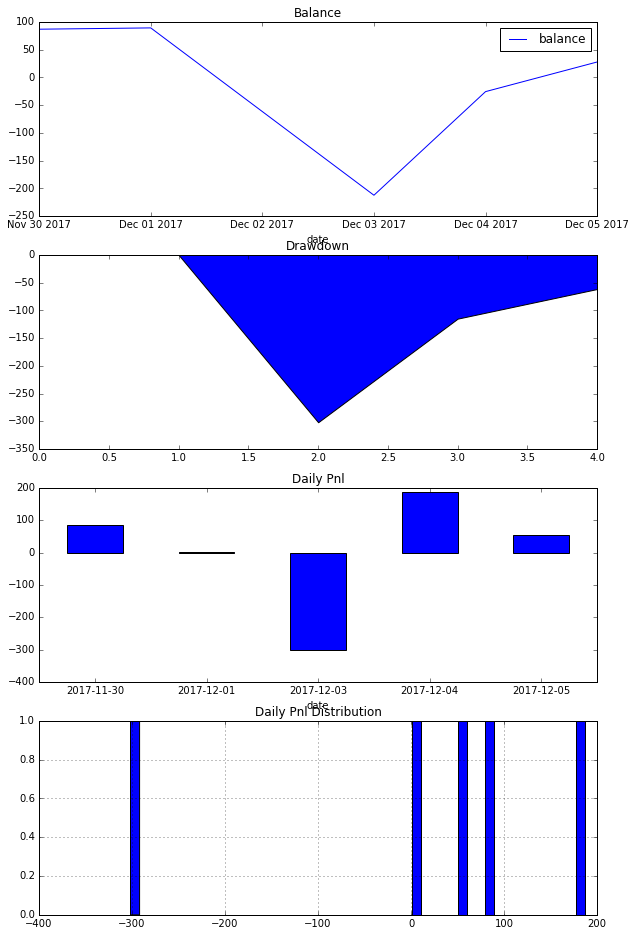

In [79]:
'''
回测
'''
#初始化数据需要的自然日天数
initDays = 1

#创建回测引擎实例
engine = BacktestingEngine()

#设置引擎的回测模式为K线
engine.setBacktestingMode(engine.TICK_MODE)

#设置回测的起始日期
engine.setStartDate(startDate, initDays = initDays) #这里的initDays是真正起作用的

#设置产品相关参数
engine.setSlippage(0)           #滑点设置为0
engine.setRate(1.0/10000)       #合约交易手续费万1
engine.setSize(10)               #合约每股为1
engine.setPriceTick(1)      #合约最小价格变动
engine.setCapital(1) #初始资金

#设置使用的数据库
engine.setDatabase(TICK_DB_NAME, vtCode)

#引擎中创建策略对象
engine.initStrategy(AtrRsiStrategy, {})

#开始跑回测
engine.runBacktesting()

#显示回测结果
engine.showDailyResult()